In [1]:
# -*- coding: utf-8 -*-
# Authors: Chitta Ranjan <cran2367@gmail.com>
#
# License: BSD 3 clause

In [2]:
import numpy as np
import pandas as pd
from itertools import chain
import warnings

########
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout, Activation, Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
np.random.seed(7) # fix random seed for reproducibility
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
import sklearn.metrics
import time

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
%matplotlib inline

from sgt import Sgt

/Users/inferno/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
tf.__version__

'2.0.0'

## Test Examples

In [4]:
sgt = Sgt()

In [5]:
sequence = np.array(["B","B","A","C","A","C","A","A","B","A"])
alphabets = ["A", "B", "C"]
lengthsensitive = True
kappa = 5

In [6]:
sgt.getpositions(sequence = sequence, alphabets = alphabets)

[('A', (array([2, 4, 6, 7, 9]),)),
 ('B', (array([0, 1, 8]),)),
 ('C', (array([3, 5]),))]

In [7]:
sgt.fit(sequence, alphabets, lengthsensitive, kappa, flatten=False)

,A,B,C
A,0.369361,0.442463,0.537637
B,0.414884,0.468038,0.162774
C,0.454136,0.068693,0.214492


In [8]:
corpus = [["B","B","A","C","A","C","A","A","B","A"], ["C", "Z", "Z", "Z", "D"]]

In [9]:
s = sgt.fit_transform(corpus)
print(s)

[[0.90616284 1.31002279 2.6184865  0.         0.         0.86569371
  1.23042262 0.52543984 0.         0.         1.37141609 0.28262508
  1.35335283 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.09157819 0.92166965 0.         0.         0.
  0.         0.         0.         0.         0.         0.92166965
  1.45182361]]


In [10]:
sequence_test = [['a', 'b'], ['a', 'b', 'c'], ['e', 'f']]

In [11]:
sequence_model_test = Sgt(kappa=10, lengthsensitive=True)

In [12]:
result_test = sequence_model_test.fit_transform(corpus=sequence_test)

In [13]:
result_test

array([[0.        , 0.39428342, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.41059877, 0.15105085, 0.        , 0.        ,
        0.        , 0.        , 0.41059877, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.39428342,
        0.        , 0.        , 0.        , 0.

In [14]:
sequence_model_test.alphabets

['a', 'b', 'c', 'e', 'f']

## Protein Sequence Data Analysis

The data used here is taken from www.uniprot.org. This is a public database for proteins. The data contains the protein sequences and their functions. In the following, we will demonstrate 
- clustering of the sequences.
- classification of the sequences with the functions as labels.

In [15]:
protein_data=pd.DataFrame.from_csv('../data/protein_classification.csv')
X=protein_data['Sequence']
def split(word): 
    return [char for char in word] 

sequences = [split(x) for x in X]
print(sequences[0])

['M', 'E', 'I', 'E', 'K', 'T', 'N', 'R', 'M', 'N', 'A', 'L', 'F', 'E', 'F', 'Y', 'A', 'A', 'L', 'L', 'T', 'D', 'K', 'Q', 'M', 'N', 'Y', 'I', 'E', 'L', 'Y', 'Y', 'A', 'D', 'D', 'Y', 'S', 'L', 'A', 'E', 'I', 'A', 'E', 'E', 'F', 'G', 'V', 'S', 'R', 'Q', 'A', 'V', 'Y', 'D', 'N', 'I', 'K', 'R', 'T', 'E', 'K', 'I', 'L', 'E', 'D', 'Y', 'E', 'M', 'K', 'L', 'H', 'M', 'Y', 'S', 'D', 'Y', 'I', 'V', 'R', 'S', 'Q', 'I', 'F', 'D', 'Q', 'I', 'L', 'E', 'R', 'Y', 'P', 'K', 'D', 'D', 'F', 'L', 'Q', 'E', 'Q', 'I', 'E', 'I', 'L', 'T', 'S', 'I', 'D', 'N', 'R', 'E']


### Generating sequence embeddings

In [16]:
sgt = Sgt(kappa = 1, lengthsensitive = False)

In [17]:
embedding = sgt.fit_transform(corpus=sequences)

In [18]:
embedding.shape

(2112, 400)

#### Sequence Clustering
We perform PCA on the sequence embeddings and then do kmeans clustering.

In [19]:
pca = PCA(n_components=2)
pca.fit(embedding)
X=pca.transform(embedding)

print(np.sum(pca.explained_variance_ratio_))
df = pd.DataFrame(data=X, columns=['x1', 'x2'])
df.head()

0.6432744907364925


,x1,x2
0,0.384913,-0.269873
1,0.022764,0.135995
2,0.177792,-0.172454
3,0.168074,-0.147334
4,0.383616,-0.271163


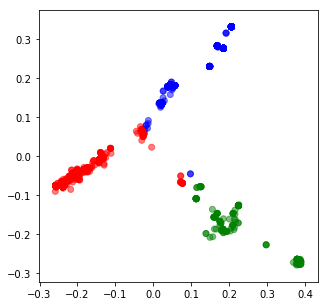

In [20]:
kmeans = KMeans(n_clusters=3, max_iter =300)
kmeans.fit(df)

labels = kmeans.predict(df)
centroids = kmeans.cluster_centers_

fig = plt.figure(figsize=(5, 5))
colmap = {1: 'r', 2: 'g', 3: 'b'}
colors = list(map(lambda x: colmap[x+1], labels))
plt.scatter(df['x1'], df['x2'], color=colors, alpha=0.5, edgecolor=colors)

#### Sequence Classification
We perform PCA on the sequence embeddings and then do kmeans clustering.

In [21]:
y = protein_data['Function [CC]']
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)

We will perform a 10-fold cross-validation to measure the performance of the classification model.

In [22]:
kfold = 10
X = pd.DataFrame(embedding)
y = encoded_y

random_state = 1

test_F1 = np.zeros(kfold)
skf = KFold(n_splits = kfold, shuffle = True, random_state = random_state)
k = 0
epochs = 50
batch_size = 128

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train = X_train.as_matrix(columns = None)
    X_test = X_test.as_matrix(columns = None)
    
    model = Sequential()
    model.add(Dense(64, input_shape = (X_train.shape[1],))) 
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    model.fit(X_train, y_train ,batch_size=batch_size, epochs=epochs, verbose=0)
    
    y_pred = model.predict_proba(X_test).round().astype(int)
    y_train_pred = model.predict_proba(X_train).round().astype(int)

    test_F1[k] = sklearn.metrics.f1_score(y_test, y_pred)
    k+=1
    
print ('Average f1 score', np.mean(test_F1))

Average f1 score 1.0


## Weblog Data Analysis
This data sample is taken from https://www.ll.mit.edu/r-d/datasets/1998-darpa-intrusion-detection-evaluation-dataset. 
This is a network intrusion data containing audit logs and any attack as a positive label. Since, network intrusion is a rare event, the data is unbalanced. Here we will,
- build a sequence classification model to predict a network intrusion.

Each sequence contains in the data is a series of activity, for example, {login, password}. The _alphabets_ in the input data sequences are already encoded into integers. The original sequences data file is also present in the `/data` directory.

In [23]:
darpa_data = pd.DataFrame.from_csv('../data/darpa_data.csv')
darpa_data.columns

Index(['seqlen', 'seq', 'class'], dtype='object')

In [24]:
X = darpa_data['seq']
sequences = [x.split('~') for x in X]

In [25]:
y = darpa_data['class']
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

### Generating sequence embeddings
In this data, the sequence embeddings should be length-sensitive. The lengths are important here because sequences with similar patterns but different lengths can have different labels. Consider a simple example of two sessions: `{login, pswd, login, pswd,...}` and `{login, pswd,...(repeated several times)..., login, pswd}`. While the first session can be a regular user mistyping the password once, the other session is possibly an attack to guess the password. Thus, the sequence lengths are as important as the patterns.

In [26]:
sgt_darpa = Sgt(kappa = 5, lengthsensitive = True)

In [27]:
embedding = sgt_darpa.fit_transform(corpus=sequences)

In [28]:
pd.DataFrame(embedding).to_csv(path_or_buf='tmp.csv', index=False)
pd.DataFrame(embedding).head()

,0,1,2,3,4,5,6,7,8,9,...,2391,2392,2393,2394,2395,2396,2397,2398,2399,2400
0,0.069114,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.0,0.000000e+00,0.000000e+00
1,0.000000,0.0,4.804190e-09,7.041516e-10,0.0,2.004958e-12,0.000132,1.046458e-07,5.863092e-16,7.568986e-23,...,0.0,0.0,0.0,0.0,0.0,0.540296,5.739230e-32,0.0,0.000000e+00,0.000000e+00
2,0.000000,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.0,0.000000e+00,0.000000e+00
3,0.785666,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000,1.950089e-03,2.239981e-04,2.343180e-07,...,0.0,0.0,0.0,0.0,0.0,0.528133,1.576703e-09,0.0,2.516644e-29,1.484843e-57
4,0.000000,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.0,0.000000e+00,0.000000e+00


#### Applying PCA on the embeddings
The embeddings are sparse. We, therefore, apply PCA on the embeddings.

In [29]:
from sklearn.decomposition import PCA
pca = PCA(n_components=35)
pca.fit(embedding)
X = pca.transform(embedding)
print(np.sum(pca.explained_variance_ratio_))

0.9887812984792304


#### Building a Multi-Layer Perceptron Classifier
The PCA transforms of the embeddings are used directly as inputs to an MLP classifier.

In [30]:
kfold = 3
random_state = 11

test_F1 = np.zeros(kfold)
time_k = np.zeros(kfold)
skf = StratifiedKFold(n_splits=kfold, shuffle=True, random_state=random_state)
k = 0
epochs = 300
batch_size = 15

# class_weight = {0 : 1., 1: 1.,}  # The weights can be changed and made inversely proportional to the class size to improve the accuracy.
class_weight = {0 : 0.12, 1: 0.88,}

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = Sequential()
    model.add(Dense(128, input_shape=(X_train.shape[1],))) 
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.summary()
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    start_time = time.time()
    model.fit(X_train, y_train ,batch_size=batch_size, epochs=epochs, verbose=1, class_weight=class_weight)
    end_time = time.time()
    time_k[k] = end_time-start_time

    y_pred = model.predict_proba(X_test).round().astype(int)
    y_train_pred = model.predict_proba(X_train).round().astype(int)
    test_F1[k] = sklearn.metrics.f1_score(y_test, y_pred)
    k += 1

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 128)               4608      
_________________________________________________________________
activation_30 (Activation)   (None, 128)               0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 129       
_________________________________________________________________
activation_31 (Activation)   (None, 1)                 0         
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________
Train on 73 samples
Epoch 1/300
73/73 [==============================] - 0s 6ms/sample - loss: 0.1492 - accuracy: 0.4

73/73 [==============================] - 0s 133us/sample - loss: 0.0286 - accuracy: 0.9178
Epoch 70/300
73/73 [==============================] - 0s 130us/sample - loss: 0.0282 - accuracy: 0.9178
Epoch 71/300
73/73 [==============================] - 0s 123us/sample - loss: 0.0300 - accuracy: 0.9178
Epoch 72/300
73/73 [==============================] - 0s 123us/sample - loss: 0.0299 - accuracy: 0.9178
Epoch 73/300
73/73 [==============================] - 0s 130us/sample - loss: 0.0280 - accuracy: 0.9178
Epoch 74/300
73/73 [==============================] - 0s 122us/sample - loss: 0.0296 - accuracy: 0.9178
Epoch 75/300
73/73 [==============================] - 0s 136us/sample - loss: 0.0266 - accuracy: 0.9178
Epoch 76/300
73/73 [==============================] - 0s 125us/sample - loss: 0.0263 - accuracy: 0.9178
Epoch 77/300
73/73 [==============================] - 0s 147us/sample - loss: 0.0233 - accuracy: 0.9178
Epoch 78/300
73/73 [==============================] - 0s 139us/sample - loss:

73/73 [==============================] - 0s 145us/sample - loss: 0.0211 - accuracy: 0.9178
Epoch 148/300
73/73 [==============================] - 0s 123us/sample - loss: 0.0217 - accuracy: 0.9178
Epoch 149/300
73/73 [==============================] - 0s 138us/sample - loss: 0.0225 - accuracy: 0.9178
Epoch 150/300
73/73 [==============================] - 0s 117us/sample - loss: 0.0219 - accuracy: 0.9178
Epoch 151/300
73/73 [==============================] - 0s 145us/sample - loss: 0.0212 - accuracy: 0.9315
Epoch 152/300
73/73 [==============================] - 0s 131us/sample - loss: 0.0220 - accuracy: 0.9178
Epoch 153/300
73/73 [==============================] - 0s 135us/sample - loss: 0.0199 - accuracy: 0.9178
Epoch 154/300
73/73 [==============================] - 0s 140us/sample - loss: 0.0213 - accuracy: 0.9178
Epoch 155/300
73/73 [==============================] - 0s 133us/sample - loss: 0.0251 - accuracy: 0.9178
Epoch 156/300
73/73 [==============================] - 0s 121us/sampl

73/73 [==============================] - 0s 131us/sample - loss: 0.0255 - accuracy: 0.9178
Epoch 225/300
73/73 [==============================] - 0s 137us/sample - loss: 0.0219 - accuracy: 0.9178
Epoch 226/300
73/73 [==============================] - 0s 124us/sample - loss: 0.0178 - accuracy: 0.9178
Epoch 227/300
73/73 [==============================] - 0s 126us/sample - loss: 0.0241 - accuracy: 0.9178
Epoch 228/300
73/73 [==============================] - 0s 138us/sample - loss: 0.0215 - accuracy: 0.9178
Epoch 229/300
73/73 [==============================] - 0s 131us/sample - loss: 0.0180 - accuracy: 0.9178
Epoch 230/300
73/73 [==============================] - 0s 129us/sample - loss: 0.0202 - accuracy: 0.9178
Epoch 231/300
73/73 [==============================] - 0s 140us/sample - loss: 0.0213 - accuracy: 0.9178
Epoch 232/300
73/73 [==============================] - 0s 128us/sample - loss: 0.0203 - accuracy: 0.9178
Epoch 233/300
73/73 [==============================] - 0s 139us/sampl

dense_33 (Dense)             (None, 1)                 129       
_________________________________________________________________
activation_33 (Activation)   (None, 1)                 0         
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________
Train on 74 samples
Epoch 1/300
74/74 [==============================] - 0s 6ms/sample - loss: 0.1477 - accuracy: 0.6216
Epoch 2/300
74/74 [==============================] - 0s 124us/sample - loss: 0.1468 - accuracy: 0.6351
Epoch 3/300
74/74 [==============================] - 0s 124us/sample - loss: 0.1320 - accuracy: 0.7568
Epoch 4/300
74/74 [==============================] - 0s 129us/sample - loss: 0.1203 - accuracy: 0.8108
Epoch 5/300
74/74 [==============================] - 0s 134us/sample - loss: 0.1267 - accuracy: 0.7568
Epoch 6/300
74/74 [==============================] - 0s 127us/sample - loss: 0.1173 - accuracy: 0.8108
Epoch 7/300
74/74 [=============

74/74 [==============================] - 0s 120us/sample - loss: 0.0316 - accuracy: 0.8919
Epoch 76/300
74/74 [==============================] - 0s 122us/sample - loss: 0.0333 - accuracy: 0.8919
Epoch 77/300
74/74 [==============================] - 0s 123us/sample - loss: 0.0323 - accuracy: 0.8919
Epoch 78/300
74/74 [==============================] - 0s 121us/sample - loss: 0.0360 - accuracy: 0.8919
Epoch 79/300
74/74 [==============================] - 0s 124us/sample - loss: 0.0317 - accuracy: 0.8919
Epoch 80/300
74/74 [==============================] - 0s 130us/sample - loss: 0.0359 - accuracy: 0.8919
Epoch 81/300
74/74 [==============================] - 0s 124us/sample - loss: 0.0309 - accuracy: 0.8919
Epoch 82/300
74/74 [==============================] - 0s 178us/sample - loss: 0.0343 - accuracy: 0.8919
Epoch 83/300
74/74 [==============================] - 0s 122us/sample - loss: 0.0319 - accuracy: 0.8919
Epoch 84/300
74/74 [==============================] - 0s 134us/sample - loss:

74/74 [==============================] - 0s 130us/sample - loss: 0.0314 - accuracy: 0.8919
Epoch 154/300
74/74 [==============================] - 0s 134us/sample - loss: 0.0304 - accuracy: 0.8919
Epoch 155/300
74/74 [==============================] - 0s 122us/sample - loss: 0.0260 - accuracy: 0.8919
Epoch 156/300
74/74 [==============================] - 0s 133us/sample - loss: 0.0319 - accuracy: 0.8919
Epoch 157/300
74/74 [==============================] - 0s 122us/sample - loss: 0.0308 - accuracy: 0.8919
Epoch 158/300
74/74 [==============================] - 0s 130us/sample - loss: 0.0293 - accuracy: 0.8919
Epoch 159/300
74/74 [==============================] - 0s 128us/sample - loss: 0.0279 - accuracy: 0.8919
Epoch 160/300
74/74 [==============================] - 0s 127us/sample - loss: 0.0281 - accuracy: 0.8919
Epoch 161/300
74/74 [==============================] - 0s 143us/sample - loss: 0.0281 - accuracy: 0.8919
Epoch 162/300
74/74 [==============================] - 0s 133us/sampl

74/74 [==============================] - 0s 145us/sample - loss: 0.0302 - accuracy: 0.8919
Epoch 232/300
74/74 [==============================] - 0s 140us/sample - loss: 0.0289 - accuracy: 0.8919
Epoch 233/300
74/74 [==============================] - 0s 128us/sample - loss: 0.0303 - accuracy: 0.8919
Epoch 234/300
74/74 [==============================] - 0s 125us/sample - loss: 0.0300 - accuracy: 0.8919
Epoch 235/300
74/74 [==============================] - 0s 127us/sample - loss: 0.0320 - accuracy: 0.8919
Epoch 236/300
74/74 [==============================] - 0s 129us/sample - loss: 0.0308 - accuracy: 0.8919
Epoch 237/300
74/74 [==============================] - 0s 126us/sample - loss: 0.0289 - accuracy: 0.8919
Epoch 238/300
74/74 [==============================] - 0s 123us/sample - loss: 0.0269 - accuracy: 0.8919
Epoch 239/300
74/74 [==============================] - 0s 130us/sample - loss: 0.0301 - accuracy: 0.8919
Epoch 240/300
74/74 [==============================] - 0s 129us/sampl

Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________
Train on 75 samples
Epoch 1/300
75/75 [==============================] - 0s 4ms/sample - loss: 0.1324 - accuracy: 0.5867
Epoch 2/300
75/75 [==============================] - 0s 109us/sample - loss: 0.1279 - accuracy: 0.7067
Epoch 3/300
75/75 [==============================] - 0s 113us/sample - loss: 0.1212 - accuracy: 0.6933
Epoch 4/300
75/75 [==============================] - 0s 117us/sample - loss: 0.1169 - accuracy: 0.7467
Epoch 5/300
75/75 [==============================] - 0s 107us/sample - loss: 0.1173 - accuracy: 0.8000
Epoch 6/300
75/75 [==============================] - 0s 124us/sample - loss: 0.1112 - accuracy: 0.7467
Epoch 7/300
75/75 [==============================] - 0s 109us/sample - loss: 0.1108 - accuracy: 0.8533
Epoch 8/300
75/75 [==============================] - 0s 116us/sample - loss: 0.1091 - accuracy: 0.7600
Epoch 9/300
75/75 [=====

Epoch 77/300
75/75 [==============================] - 0s 131us/sample - loss: 0.0410 - accuracy: 0.8533
Epoch 78/300
75/75 [==============================] - 0s 188us/sample - loss: 0.0416 - accuracy: 0.8533
Epoch 79/300
75/75 [==============================] - 0s 144us/sample - loss: 0.0445 - accuracy: 0.8533
Epoch 80/300
75/75 [==============================] - 0s 158us/sample - loss: 0.0430 - accuracy: 0.8533
Epoch 81/300
75/75 [==============================] - 0s 137us/sample - loss: 0.0374 - accuracy: 0.8533
Epoch 82/300
75/75 [==============================] - 0s 119us/sample - loss: 0.0466 - accuracy: 0.8533
Epoch 83/300
75/75 [==============================] - 0s 127us/sample - loss: 0.0396 - accuracy: 0.8533
Epoch 84/300
75/75 [==============================] - 0s 173us/sample - loss: 0.0459 - accuracy: 0.8533
Epoch 85/300
75/75 [==============================] - 0s 152us/sample - loss: 0.0483 - accuracy: 0.8533
Epoch 86/300
75/75 [==============================] - 0s 120us/s

75/75 [==============================] - 0s 126us/sample - loss: 0.0390 - accuracy: 0.8533
Epoch 155/300
75/75 [==============================] - 0s 125us/sample - loss: 0.0380 - accuracy: 0.8533
Epoch 156/300
75/75 [==============================] - 0s 125us/sample - loss: 0.0377 - accuracy: 0.8533
Epoch 157/300
75/75 [==============================] - 0s 164us/sample - loss: 0.0387 - accuracy: 0.8533
Epoch 158/300
75/75 [==============================] - 0s 136us/sample - loss: 0.0365 - accuracy: 0.8533
Epoch 159/300
75/75 [==============================] - 0s 115us/sample - loss: 0.0405 - accuracy: 0.8533
Epoch 160/300
75/75 [==============================] - 0s 123us/sample - loss: 0.0362 - accuracy: 0.8533
Epoch 161/300
75/75 [==============================] - 0s 127us/sample - loss: 0.0385 - accuracy: 0.8533
Epoch 162/300
75/75 [==============================] - 0s 116us/sample - loss: 0.0360 - accuracy: 0.8533
Epoch 163/300
75/75 [==============================] - 0s 130us/sampl

75/75 [==============================] - 0s 110us/sample - loss: 0.0388 - accuracy: 0.8533
Epoch 233/300
75/75 [==============================] - 0s 111us/sample - loss: 0.0377 - accuracy: 0.8533
Epoch 234/300
75/75 [==============================] - 0s 122us/sample - loss: 0.0362 - accuracy: 0.8533
Epoch 235/300
75/75 [==============================] - 0s 129us/sample - loss: 0.0332 - accuracy: 0.8533
Epoch 236/300
75/75 [==============================] - 0s 122us/sample - loss: 0.0361 - accuracy: 0.8533
Epoch 237/300
75/75 [==============================] - 0s 145us/sample - loss: 0.0404 - accuracy: 0.8533
Epoch 238/300
75/75 [==============================] - 0s 143us/sample - loss: 0.0368 - accuracy: 0.8533
Epoch 239/300
75/75 [==============================] - 0s 112us/sample - loss: 0.0362 - accuracy: 0.8533
Epoch 240/300
75/75 [==============================] - 0s 141us/sample - loss: 0.0409 - accuracy: 0.8667
Epoch 241/300
75/75 [==============================] - 0s 133us/sampl

In [31]:
print ('Average f1 score', np.mean(test_F1))
print ('Average Run time', np.mean(time_k))

Average f1 score 0.5851851851851851
Average Run time 3.7768200238545737


#### Building an LSTM Classifier on the sequences for comparison
We built an LSTM Classifier on the sequences to compare the accuracy.

In [32]:
X = darpa_data['seq']
encoded_X = np.ndarray(shape=(len(X),), dtype=list)
for i in range(0,len(X)):
    encoded_X[i]=X.iloc[i].split("~")

In [33]:
max_seq_length = np.max(darpa_data['seqlen'])
encoded_X = tf.keras.preprocessing.sequence.pad_sequences(encoded_X, maxlen=max_seq_length)

In [34]:
kfold = 3
random_state = 11

test_F1 = np.zeros(kfold)
time_k = np.zeros(kfold)

epochs = 50
batch_size = 15
skf = StratifiedKFold(n_splits=kfold, shuffle=True, random_state=random_state)
k = 0

for train_index, test_index in skf.split(encoded_X, y):
    X_train, X_test = encoded_X[train_index], encoded_X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    embedding_vecor_length = 32
    top_words=50
    model = Sequential()
    model.add(Embedding(top_words, embedding_vecor_length, input_length=max_seq_length))
    model.add(LSTM(32))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    model.summary()
    
    start_time = time.time()
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
    end_time=time.time()
    time_k[k]=end_time-start_time

    y_pred = model.predict_proba(X_test).round().astype(int)
    y_train_pred=model.predict_proba(X_train).round().astype(int)
    test_F1[k]=sklearn.metrics.f1_score(y_test, y_pred)
    k+=1

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1773, 32)          1600      
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 33        
_________________________________________________________________
activation_36 (Activation)   (None, 1)                 0         
Total params: 9,953
Trainable params: 9,953
Non-trainable params: 0
_________________________________________________________________
Train on 73 samples
Epoch 1/50
73/73 [==============================] - 6s 83ms/sample - loss: 0.6854 - accuracy: 0.7123
Epoch 2/50
73/73 [==============================] - 4s 53ms/sample - loss: 0.6532 - accuracy: 0.8904
Epoch 3/50
73/73 [=========

74/74 [==============================] - 3s 45ms/sample - loss: 0.3705 - accuracy: 0.8784
Epoch 14/50
74/74 [==============================] - 3s 45ms/sample - loss: 0.3693 - accuracy: 0.8784
Epoch 15/50
74/74 [==============================] - 3s 45ms/sample - loss: 0.3696 - accuracy: 0.8784
Epoch 16/50
74/74 [==============================] - 3s 45ms/sample - loss: 0.3686 - accuracy: 0.8784
Epoch 17/50
74/74 [==============================] - 3s 47ms/sample - loss: 0.3694 - accuracy: 0.8784
Epoch 18/50
74/74 [==============================] - 3s 45ms/sample - loss: 0.3677 - accuracy: 0.8784
Epoch 19/50
74/74 [==============================] - 3s 47ms/sample - loss: 0.3671 - accuracy: 0.8784
Epoch 20/50
74/74 [==============================] - 3s 45ms/sample - loss: 0.3656 - accuracy: 0.8784
Epoch 21/50
74/74 [==============================] - 3s 45ms/sample - loss: 0.3654 - accuracy: 0.8784
Epoch 22/50
74/74 [==============================] - 4s 48ms/sample - loss: 0.3638 - accuracy:

75/75 [==============================] - 3s 42ms/sample - loss: 0.3496 - accuracy: 0.8800
Epoch 35/50
75/75 [==============================] - 3s 42ms/sample - loss: 0.3425 - accuracy: 0.8800
Epoch 36/50
75/75 [==============================] - 3s 42ms/sample - loss: 0.3194 - accuracy: 0.8800
Epoch 37/50
75/75 [==============================] - 3s 44ms/sample - loss: 0.3053 - accuracy: 0.8800
Epoch 38/50
75/75 [==============================] - 3s 44ms/sample - loss: 0.2906 - accuracy: 0.8800
Epoch 39/50
75/75 [==============================] - 4s 51ms/sample - loss: 0.2786 - accuracy: 0.8800
Epoch 40/50
75/75 [==============================] - 3s 46ms/sample - loss: 0.3188 - accuracy: 0.8800
Epoch 41/50
75/75 [==============================] - 3s 44ms/sample - loss: 0.2884 - accuracy: 0.8800
Epoch 42/50
75/75 [==============================] - 3s 44ms/sample - loss: 0.3086 - accuracy: 0.8800
Epoch 43/50
75/75 [==============================] - 3s 44ms/sample - loss: 0.2544 - accuracy:

In [35]:
print ('Average f1 score', np.mean(test_F1))
print ('Average Run time', np.mean(time_k))

Average f1 score 0.48888888888888893
Average Run time 180.2923804918925


We find that the LSTM classifier gives an F1 score of 0. This may be improved by changing the model. However, we find that the SGT embedding could work with a small and unbalanced data without the need of a complicated classifier model.

LSTM models typically require more data for training and also has significantly more computation time. The LSTM model above took 425.6 secs while the MLP model took just 9.1 secs.